### imports

In [1]:
import math
import lucene
import pickle
import time
import matplotlib.pyplot as plt
import itertools
import numpy as np
from tqdm import tqdm
from java.io import File
import xml.etree.ElementTree as ET
from collections import defaultdict
from org.apache.lucene.store import FSDirectory
from org.apache.lucene.util import BytesRefIterator
from org.apache.lucene.index import DirectoryReader, Term
from org.apache.lucene.analysis.en import EnglishAnalyzer
from org.apache.lucene.analysis.core import WhitespaceAnalyzer
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.search import IndexSearcher, BooleanQuery, BooleanClause, TermQuery, BoostQuery
from org.apache.lucene.search.similarities import BM25Similarity, LMJelinekMercerSimilarity, LMDirichletSimilarity
lucene.initVM()

In [2]:
index_path = '/archive/TREC678/documents_index/'
# topicFilePath = '/archive/Priyanshu/clue-web/clueweb09-title.xml'

directory = FSDirectory.open(File(index_path).toPath())
indexReader = DirectoryReader.open(directory)


In [6]:
a= indexReader.document(0)

### document preprocessing

In [3]:
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_short


def alpha(text):
    a = text.split()
    j = [k for k in a if k.isalpha()]
    return ' '.join(j)

def getprocessdoc(doc_num):
    p = PorterStemmer()
    doc = indexReader.document(doc_num)  
    raw_doc =  doc.get('CONTENTS')
    ids = doc.get('ID')

    no_punc = strip_punctuation(raw_doc)
    stemed_doc = p.stem_sentence(no_punc)
    no_stopword = remove_stopwords(stemed_doc)
    no_nonalpha = alpha(no_stopword)
    pro_doc = strip_short(no_nonalpha, minsize=4)

    return pro_doc


In [4]:
getprocessdoc(0)

'daili report econom agricultur guangdong seek billion foreign invest guangdong seek billion foreign invest beij china daili busi weekli english beij china daili busi weekli english zheng caixiong guangdong need invest worth year text guangzhou guangdong estim need attract billion foreign invest help realiz ambiti modern plan year achiev goal south china provinc open sector foreign invest apart special industri fall central control said ruihua manag vice governor interview busi weekli week addit improv infrastructur guangdong expect concret market framework introduc econom develop line intern practic said hope creat better invest climat offer market stock effici oversea investor earn monei provinc said foreign invest develop infrastructur industri like energi transport telecommun ethylen automobil electron textil medicin meanwhil guangdong steer foreign invest high tech industri high valu sector export orient agricultur rural area hope foreign invest arriv develop labour intens process

In [37]:
def getdoc(num):
    for i in tqdm(range(num)):
        yield getprocessdoc(i)

### tf-idf vectorization using scikitlearn

In [71]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.4, min_df=10)
total_doc = indexReader.numDocs()
X = vectorizer.fit_transform(getdoc(total_doc))

100%|██████████| 528155/528155 [09:54<00:00, 887.73it/s] 


In [87]:
X

<528155x73464 sparse matrix of type '<class 'numpy.float64'>'
	with 71542455 stored elements in Compressed Sparse Row format>

In [89]:
with open('cleaned_doc.vec', 'wb') as fin:
     pickle.dump(X, fin, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open('cleaned_doc.vec', 'rb') as handle:
    X_tfidf = pickle.load(handle)

In [19]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from time import time
import pickle

with open('cleaned_doc.vec', 'rb') as handle:
    X_tfidf = pickle.load(handle)


lsa = make_pipeline(TruncatedSVD(n_components=2), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

# with open('dim-red-vec.pickle', 'wb') as handle:
#     pickle.dump(X_lsa, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     print('doc-vec saved successfully to file')

LSA done in 5.219 s
Explained variance of the SVD step: 1.5%


In [109]:
from sklearn.cluster import KMeans, MiniBatchKMeans
true_k = 100
 
# for seed in range(5):
#     kmeans = KMeans(
#         n_clusters=true_k,
#         max_iter=100,
#         n_init=1,
#         random_state=seed,
#     ).fit(X)
#     cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
#     print(f"Number of elements assigned to each cluster: {cluster_sizes}")
# print()


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
k_range = range(2,20)

sse = []

for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(X_tfidf)
    preds = km.fit_predict(X_tfidf)
    centers = km.cluster_centers_
    score = silhouette_score(X_tfidf, preds)
    print("For n_clusters = {}, silhouette score is {})".format(k, score))
    sse.append(km.inertia_)

In [ ]:
plt.plot(k_range, sse)

In [20]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans

# k_range = range(2,20)
k_range = [100]

sse = []

for k in k_range:
    km = MiniBatchKMeans(n_clusters=k, batch_size=6000,
        max_iter=100,
        n_init=5,
        random_state=1, verbose=True).fit(X_lsa)
   
    preds = km.fit_predict(X_lsa)

    centers = km.cluster_centers_
    doc_labels = km.labels_
    # score = silhouette_score(X, preds)
    # print("For n_clusters = {}, silhouette score is {})".format(k, score))
    sse.append(km.inertia_)

Init 1/5 with method k-means++
Inertia for init 1/5: 0.8131460934990498
Init 2/5 with method k-means++
Inertia for init 2/5: 0.8001849921494194
Init 3/5 with method k-means++
Inertia for init 3/5: 0.808760448652096
Init 4/5 with method k-means++
Inertia for init 4/5: 0.7707530576099133
Init 5/5 with method k-means++
Inertia for init 5/5: 0.7741522624032409
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch step 1/8802: mean batch inertia: 4.1594422121685346e-05
Minibatch step 2/8802: mean batch inertia: 0.0007042091752306175, ewa inertia: 0.0007042091752306175
Minibatch step 3/8802: mean batch inertia: 0.000131847172146701, ewa inertia: 0.000691204790092501
Minibatch step 4/8802: mean batch inertia: 0.00011954861084225251, ewa inertia: 0.0006782164416670302
Minibatch step 5/8802: mean batch inertia: 0.00025887060604714055, ewa inertia: 0.0006686886695174406
Minibatch step 6/8802: mean batch inertia: 0.0001436330654016252, ewa inertia: 0.0006567591122476382
Minibatch step 7/8802

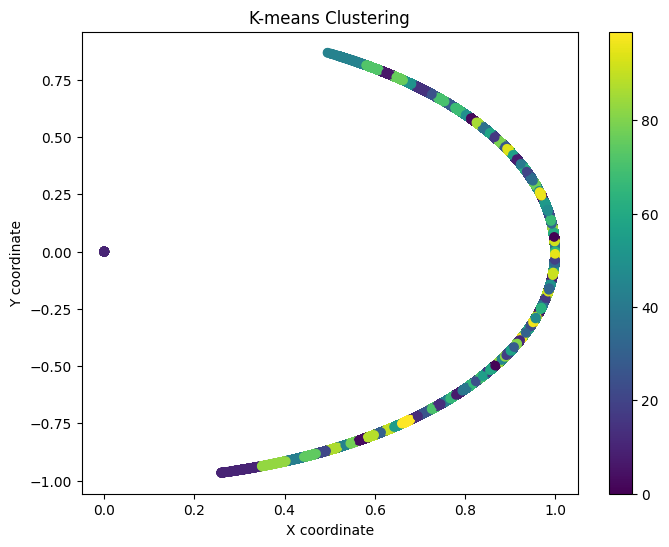

Number of elements id [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99] 
 assigned to each cluster: [ 3788 11304  4157  2323  8538  4224  1847  5773  4594  6219   790 10146
  2241  2214  3856 10505  4413  7177 12450  4304  4801  2049  4428  9114
  8071  3931  2258  4112  3827 11949  1970  9056  6126  3726  4783  4345
  4521  3769  8154  7194  4812  2874  1365  2130   657 11092  4253  8120
  4619  4139  6408  3223  5112  4574  1989  8465  4230 12601  4580 11290
  9435  3702  4878  8516  3677  7767  4109  4142  4006  5503  4025  2085
  1321  8807  4570  1735  2468  4336  2317  4272  6133 11242 11957   985
 11028  3584  4181  2054  2189  8088  2012  5679  3814  6100  4067  3827
  4098  8600  9129  2137]


In [31]:
labels = doc_labels
x_coords = X_lsa[:, 0]
y_coords = X_lsa[:, 1]

# Plot scatter plot with different colors for each cluster
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=labels, cmap='viridis')
plt.colorbar()

# Add labels and title
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('K-means Clustering')

# Show the plot
plt.show()

cluster_ids, cluster_sizes = np.unique(km.labels_, return_counts=True)
print(f"Number of elements id {cluster_ids} \n assigned to each cluster: {cluster_sizes}")